<a href="https://colab.research.google.com/github/anshkumar/elf/blob/master/elf_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "./drive/My Drive/data.zip" .

In [0]:
!cp "./drive/My Drive/temp_qld.pkl" .

In [0]:
!unzip ./data.zip

Archive:  ./data.zip
   creating: data/
   creating: data/VIC/
  inflating: data/VIC/PRICE_AND_DEMAND_201501_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201711_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201710_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201612_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201706_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201707_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201604_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201605_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201510_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201511_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201701_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201609_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201608_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201603_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201602_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201507_VIC1.csv  
  inflating: data/VIC/PRI

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.5 GB  | Proc size: 693.4 MB
GPU RAM Free: 11325MB | Used: 116MB | Util   1% | Total 11441MB


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  9 19:05:59 2018

@author: vedanshu
"""

from collections import UserList, UserDict
from typing import Union, Iterable, Tuple, Dict, Any

import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import os.path

def _meta_file(path):
    return os.path.join(path, 'feeder_meta.pkl')


class VarFeeder:
    """
    Builds temporary TF graph, injects variables into, and saves variables to TF checkpoint.
    In a train time, variables can be built by build_vars() and content restored by FeederVars.restore()
    """
    def __init__(self, path: str,
                 tensor_vars: Dict[str, Union[pd.DataFrame, pd.Series, np.ndarray]] = None,
                 plain_vars: Dict[str, Any] = None):
        """
        :param path: dir to store data
        :param tensor_vars: Variables to save as Tensors (pandas DataFrames/Series or numpy arrays)
        :param plain_vars: Variables to save as Python objects
        """
        tensor_vars = tensor_vars or dict()

        def get_values(v):
            v = v.values if hasattr(v, 'values') else v
            if not isinstance(v, np.ndarray):
                v = np.array(v)
            if v.dtype == np.float64:
                v = v.astype(np.float32)
            return v

        values = [get_values(var) for var in tensor_vars.values()]

        self.shapes = [var.shape for var in values]
        self.dtypes = [v.dtype for v in values]
        self.names = list(tensor_vars.keys())
        self.path = path
        self.plain_vars = plain_vars

        if not os.path.exists(path):
            os.mkdir(path)

        with open(_meta_file(path), mode='wb') as file:
            pickle.dump(self, file)

        with tf.Graph().as_default():
            tensor_vars = self._build_vars()
            placeholders = [tf.placeholder(tf.as_dtype(dtype), shape=shape) for dtype, shape in
                            zip(self.dtypes, self.shapes)]
            assigners = [tensor_var.assign(placeholder) for tensor_var, placeholder in
                         zip(tensor_vars, placeholders)]
            feed = {ph: v for ph, v in zip(placeholders, values)}
            saver = tf.train.Saver(self._var_dict(tensor_vars), max_to_keep=1)
            init = tf.global_variables_initializer()

            with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
                sess.run(init)
                sess.run(assigners, feed_dict=feed)
                save_path = os.path.join(path, 'feeder.cpt')
                saver.save(sess, save_path, write_meta_graph=False, write_state=False)

    def _var_dict(self, variables):
        return {name: var for name, var in zip(self.names, variables)}

    def _build_vars(self):
        def make_tensor(shape, dtype, name):
            tf_type = tf.as_dtype(dtype)
            if tf_type == tf.string:
                empty = ''
            elif tf_type == tf.bool:
                empty = False
            else:
                empty = 0
            init = tf.constant(empty, shape=shape, dtype=tf_type)
            return tf.get_local_variable(name=name, initializer=init, dtype=tf_type)

        with tf.device("/cpu:0"):
            with tf.name_scope('feeder_vars'):
                return [make_tensor(shape, dtype, name) for shape, dtype, name in
                        zip(self.shapes, self.dtypes, self.names)]

    def create_vars(self):
        """
        Builds variable list to use in current graph. Should be called during graph building stage
        :return: variable list with additional restore and create_saver methods
        """
        return FeederVars(self._var_dict(self._build_vars()), self.plain_vars, self.path)

    @staticmethod
    def read_vars(path):
        with open(_meta_file(path), mode='rb') as file:
            feeder = pickle.load(file)
        assert feeder.path == path
        return feeder.create_vars()


class FeederVars(UserDict):
    def __init__(self, tensors: dict, plain_vars: dict, path):
        variables = dict(tensors)
        if plain_vars:
            variables.update(plain_vars)
        super().__init__(variables)
        self.path = path
        self.saver = tf.train.Saver(tensors, name='varfeeder_saver')
        for var in variables:
            if var not in self.__dict__:
                self.__dict__[var] = variables[var]

    def restore(self, session):
        """
        Restores variable content
        :param session: current session
        :return: variable list
        """
        self.saver.restore(session, os.path.join(self.path, 'feeder.cpt'))
        return self

There appears to be a weekly pattern so this is the initial clue used. There are two commonly used methods of encoding what day of the week it is. Seven inputs could be created with the day in question having a value of ‘1’ and the remaining six days having a value of ‘0’, a system known as ‘flagging’. Alternatively the day could be transformed into an angle (in steps of 2π/7) and the sine and cosine of this angle applied as two inputs [1]. This second scheme was chosen, the consequences of which will become apparent later.

[1] L. Tarassenko, A Guide to Neural Computing Applications, Arnold, 1998, pg. 85.


Data start: 2015-01-01 00:30:00, end:2018-01-01 00:00:00, features_end:2018-01-01 00:00:00, n_features:52608
                       RRP
Datetime                  
2015-01-01 00:30:00  45.85
2015-01-01 01:00:00  44.65
2015-01-01 01:30:00  34.24
2015-01-01 02:00:00  31.91
2015-01-01 02:30:00  29.95

Temperature data start: 2015-01-01 00:00:00, end:2018-01-01 00:00:00, n_features:1097
                     0           1           2
Datetime                                      
2015-01-01  351.928571  240.857143  283.000000
2015-01-02  342.214286  236.428571  274.000000
2015-01-03  325.214286  234.214286  266.000000
2015-01-04  321.357143  231.214286  274.666667
2015-01-05  305.642857  222.285714  248.666667

Hourly demand
           RRP
0    51.006702
1    45.477336
2    41.259585
3    39.134416
4    39.541911
5    44.173298
6    55.237117
7    85.717026
8    68.991072
9    65.673440
10   62.730397
11   63.235693
12   62.878353
13   67.969110
14   76.456907
15   87.049165
16  136.518695


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


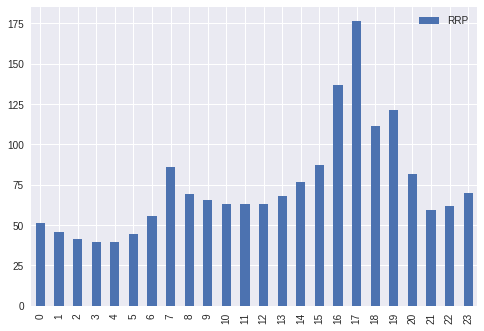

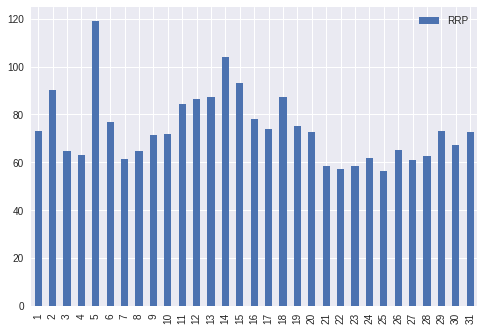

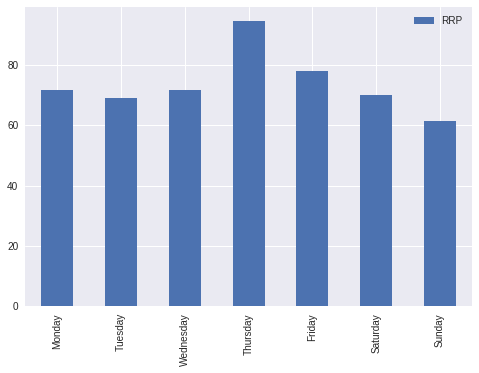

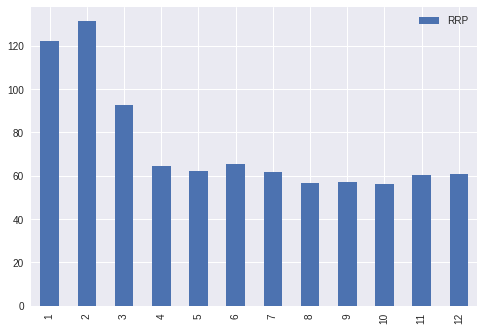

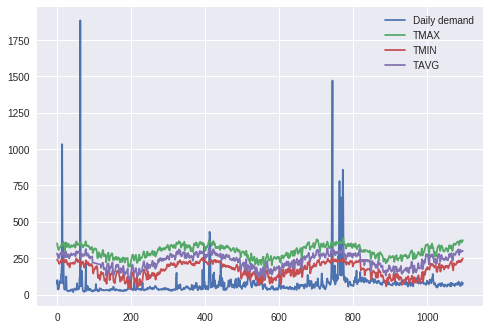

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct  4 12:02:32 2018

@author: vedanshu
"""

import pandas as pd
import numpy as np
import os.path
import os
import argparse
import pickle
import matplotlib.pyplot as plt
from typing import List

"""
Holiday package
https://pypi.org/project/holidays/
"""
!pip install holidays
import holidays
from datetime import date

def read_all() -> pd.DataFrame:
    """
    Reads source data for training/prediction
    """
    # Path to cached data
    path = os.path.join('data', 'all.pkl')
    if os.path.exists(path):
        df = pd.read_pickle(path)
        return df
    else:
        state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
        year = {0: '2015', 1: '2016', 2: '2017'}
        
        df_nsw = pd.DataFrame()
        df_qld = pd.DataFrame()
        df_sa = pd.DataFrame()
        df_tas = pd.DataFrame()
        df_vic = pd.DataFrame()
        
        df_all = pd.DataFrame()
        
        df = {'NSW': df_nsw, 'QLD': df_qld, 'SA': df_sa, 'TAS': df_tas, 'VIC': df_vic}
        
        for st in state.values():
            for ye in year.values():
                for mn in range(1,13):
                    if mn < 10:            
                        dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                    else:
                        dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                    df[st] = df[st].append(dataset.iloc[:,[0,1,3]])
            df_all = df_all.append(df[st].iloc[:,:])
        df_all['Datetime'] = pd.to_datetime(df_all['SETTLEMENTDATE'])
        df_all = df_all.set_index(['REGION','Datetime'])
        df_all = df_all.drop(['SETTLEMENTDATE'], axis=1)
        df_all.to_pickle(path)
        return df_all
    
def read_x(state, start, end) -> pd.DataFrame:
    """
    Gets source data from start to end date. Any date can be None
    """
    def read_state(state):
        df = read_all()
        return df.loc[state]
    df = read_state(state)
    if start and end:
        return df.loc[start:end]
    elif end:
        return df.loc[:end]
    else:
        return df

def single_autocorr(series, lag):
    """
    Autocorrelation for single data series
    :param series: traffic series
    :param lag: lag, days
    :return:
    """
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

def batch_autocorr(series, lag, starts, ends, backoffset=0):
    """
    Calculate autocorrelation for batch (many time series at once)
    :param data: Time series
    :param lag: Autocorrelation lag
    :param starts: Start index for series
    :param ends: End index for series
    :param backoffset: Offset from the series end, days.
    :return: autocorrelation, shape [n_series].
    """
    n_series = series.shape[0]
    max_end = n_series - backoffset
    
    end = min(ends, max_end)
    series = series[starts:end]
    c_365 = single_autocorr(series, lag)
    c_364 = single_autocorr(series, lag-1)
    c_366 = single_autocorr(series, lag+1)
    # Average value between exact lag and two nearest neighborhs for smoothness
    corr = 0.5 * c_365 + 0.25 * c_364 + 0.25 * c_366
    return corr #, support

def prepare_data(start, end, state) -> pd.DataFrame:
    """
    Reads source data, calculates start and end of each series, drops bad series, calculates log1p(series)
    :param start: start date of effective time interval, can be None to start from beginning
    :param end: end date of effective time interval, can be None to return all data
    :param state: state of series
    :return: log1p(series)
    """
    df = read_x(state, start, end)
    return df.fillna(0)

def normalize(values: np.ndarray):
    return (values - values.mean()) / np.std(values)

def lag_indexes(begin, end) -> List[pd.Series]:
    """
    Calculates indexes for 3, 6, 9, 12 months backward lag for the given date range
    :param begin: start of date range
    :param end: end of date range
    :return: List of 4 Series, one for each lag. For each Series, index is date in range(begin, end), value is an index
     of target (lagged) date in a same Series. If target date is out of (begin,end) range, index is -1
    """
    dr = pd.date_range(begin, end, freq='0.5H')
    # key is date, value is day index
    base_index = pd.Series(np.arange(0, len(dr)), index=dr)

    def lag(offset):
        dates = dr - offset
        return pd.Series(data=base_index.loc[dates].fillna(-1).astype(np.int32).values, index=dr)

    return [lag(pd.DateOffset(months=m)) for m in (3, 6, 9, 12)]

def run():
    
    state = "QLD1" 
    data_dir = "data/vars/"+state
    add_end = 0
    start = pd.to_datetime("2015/01/01 00:00:00")
    end = pd.to_datetime("2018/01/01 00:00:00")
    corr_backoffset = 0
    
    # Get the data
    df = prepare_data("","",state)
    
    # Our working date range
    data_start, data_end = pd.to_datetime(df.first_valid_index()), pd.to_datetime(df.last_valid_index())
    
    # We have to project some date-dependent features (day of week, etc) to the future dates for prediction
    features_end = data_end + pd.Timedelta(add_end/2, unit='h')
    print(f"\nData start: {data_start}, end:{data_end}, features_end:{features_end}, n_features:{df.shape[0]}")
    print(df.head())
    
    didx = pd.date_range(data_start,features_end, freq ='0.5H') 
    
    #Holidays
    hdays = holidays.CountryHoliday('AU', state=state)
    hdays_series = pd.Series(np.random.randn(len(didx)), index=didx)
    
    for date in didx:
      if date in hdays:
        hdays_series.loc[date] = 1
      else:
        hdays_series.loc[date] = 0
        
   
    #Temperature
    """
    TMAX = Maximum temperature (tenths of degrees C)
    TMIN = Minimum temperature (tenths of degrees C)
    TAVG = Average temperature (tenths of degrees C)
    """ 
    pickle_in = open("temp_qld.pkl","rb")
    temp_qld = pickle.load(pickle_in)
    temp_qld = temp_qld.interpolate()
    df_temp = temp_qld[start:end]
    print(f"\nTemperature data start: {pd.to_datetime(df_temp.first_valid_index())}, end:{pd.to_datetime(df_temp.last_valid_index())}, n_features:{df_temp.shape[0]}")
    print(df_temp.head())
    
    tmax_series = pd.Series(np.random.randn(len(didx)), index=didx)
    tmin_series = pd.Series(np.random.randn(len(didx)), index=didx)
    tavg_series = pd.Series(np.random.randn(len(didx)), index=didx)
    
    for date_time, date in zip(didx,didx.date):
        tmax_series.loc[date_time] = df_temp.loc[date][0]
        
    for date_time, date in zip(didx,didx.date):
        tmin_series.loc[date_time] = df_temp.loc[date][1]
        
    for date_time, date in zip(didx,didx.date):
        tavg_series.loc[date_time] = df_temp.loc[date][2]
        
    
    """
    ############################################################################
    Feature testing
    """
    
    #Hour of the day
    hour_df = df.groupby(didx.hour).mean()
    print("\nHourly demand")
    print (hour_df)
    hour_df.plot(kind='bar')
    
    #Day of the month
    day_df = df.groupby(didx.day).mean()
    print("\nDaily demand")
    print (day_df)
    day_df.plot(kind='bar')
    
    #Day of the week
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
    week_df = df.groupby(didx.weekday_name).mean().reindex(days)
    print("\nWeekly demand")
    print (week_df)
    week_df.plot(kind='bar')
    
    #Month of the year
    month_df = df.groupby(didx.month).mean()
    print("\nMonthly demand")
    print (month_df)
    month_df.plot( kind='bar')
    
    #Temperature and demand relationship
    daily_demand_df = df.groupby(didx.date).mean()
    assert daily_demand_df.shape[0] == df_temp.shape[0]
    plt.figure()
    plt.plot(range(daily_demand_df.shape[0]), daily_demand_df.iloc[:], label='Daily demand')
    plt.plot(range(df_temp.shape[0]), df_temp.iloc[:,0], label='TMAX')
    plt.plot(range(df_temp.shape[0]), df_temp.iloc[:,1], label='TMIN')
    plt.plot(range(df_temp.shape[0]), df_temp.iloc[:,2], label='TAVG')
    plt.legend()
    
    ############################################################################
    
    starts = 0
    ends = df.shape[0]
    
    # Yearly(annual) autocorrelation
    year_autocorr = batch_autocorr(df.values, 365, starts, ends, corr_backoffset)
    
    # Quarterly autocorrelation
    quarter_autocorr = batch_autocorr(df.values, int(round(365.25/4)), starts, ends, corr_backoffset)
    
    # Make time-dependent features
    features = pd.date_range(data_start, features_end, freq='0.5H')
    
    #day of the week (dow)
    week_period = 7 / (2 * np.pi)
    dow_norm = features.dayofweek.values / week_period
    dow = np.stack([np.cos(dow_norm), np.sin(dow_norm)], axis=-1)
    print("\nday of the week (dow)\n")
    print(dow)
    
    #hour of the day (hod)
    day_period = 24 / (2 * np.pi)
    hod_norm = features.hour.values / day_period
    hod = np.stack([np.cos(hod_norm), np.sin(hod_norm)], axis=-1)
    print("\nhour of the day (hod)\n")
    print(hod)
    
    #time of year (toy)
    year_period = 12 / (2 * np.pi)
    toy_norm = features.month.values / year_period
    toy = np.stack([np.cos(toy_norm), np.sin(toy_norm)], axis=-1)
    print("\ntime of year (toy)\n")
    print(toy)
    
    # Assemble indices for quarterly lagged data
    lagged_ix = np.stack(lag_indexes(data_start, features_end), axis=-1)
    
    # Assemble final output
    tensors = dict(
        hits=df,
        lagged_ix=lagged_ix,
#         page_ix=df.index.values,
        dow=dow,
        hod=hod,
        toy=toy,
        hday=hdays_series.values,
        tmax=tmax_series.values,
        tmin=tmin_series.values,
        tavg=tavg_series.values
        )
    plain = dict(
        features=len(features),
        year_autocorr=year_autocorr,
        quarter_autocorr=quarter_autocorr,
        data_size=df.shape[0],
        data_start=data_start,
        data_end=data_end,
        features_end=features_end
        )
   
    # Store data to the disk
    VarFeeder(data_dir, tensors, plain)

if __name__ == '__main__':
    run()

# !zip -r tensor_checkpoints_QLD1.zip data/vars/QLD1/
# !cp tensor_checkpoints_QLD1.zip "./drive/My Drive/"

In [0]:
!cp "./drive/My Drive/tensor_checkpoints_QLD1.zip" .
!unzip tensor_checkpoints_QLD1.zip

Archive:  tensor_checkpoints_QLD1.zip
   creating: data/vars/QLD1/
  inflating: data/vars/QLD1/feeder.cpt.data-00000-of-00001  
  inflating: data/vars/QLD1/feeder_meta.pkl  
  inflating: data/vars/QLD1/feeder.cpt.index  


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  9 20:09:16 2018

@author: vedanshu
"""

from enum import Enum
import tensorflow as tf

class ModelMode(Enum):
  TRAIN = 0,
  EVAL = 1,
  PREDICT = 2

class InputPipe:
  def __init__(self, inp: VarFeeder, mode: ModelMode, n_epoch=None,
               batch_size=32, runs_in_burst=1, verbose=True, predict_window=48, train_window=36, back_offset=0,
               train_skip_first=0, rand_seed=None):
      """
      Create data preprocessing pipeline
      :param inp: Raw input data
      :param features: Features tensors (subset of data in inp)
      :param mode: Train/Predict/Eval mode selector
      :param n_epoch: Number of epochs. Generates endless data stream if None
      :param batch_size: (https://www.tensorflow.org/guide/datasets#batching_dataset_elements)
      :param n_splits: number of time series split
      :param runs_in_burst: How many batches can be consumed at short time interval (burst). Multiplicator for prefetch() (https://www.tensorflow.org/performance/datasets_performance)
      :param verbose: Print additional information during graph construction
      :param predict_window: Number of days to predict
      :param train_window: Use train_window days for traning
      :param back_offset: Don't use back_offset days at the end of timeseries
      :param train_skip_first: Don't use train_skip_first days at the beginning of timeseries
      :param rand_seed:
      """
      self.inp = inp
      self.batch_size = batch_size
      self.rand_seed = rand_seed
      self.back_offset = back_offset
      self.start_offset = train_skip_first
      self.train_window = train_window
      self.predict_window = predict_window
      self.mode = mode
      self.verbose = verbose
      
#       def tile_temp(size, features):
#         # [n_features] => [n_features, size]
#         features = tf.reshape(features, (-1,1))
#         features = tf.tile(features, [1, size])
#         print("temp shape: ", features.shape)
#         features = tf.reshape(features, [-1 , (train_window + predict_window), 1])
#         return features
      
      list_half_hourly_load = self.inp.hits[train_skip_first:(-back_offset if back_offset > 0 else None)]
      self.hits_norm = tf.linalg.norm(list_half_hourly_load)
      list_half_hourly_load = list_half_hourly_load / self.hits_norm
      offset = (list_half_hourly_load.shape[0].value % (train_window + predict_window))
      matrix_hits = list_half_hourly_load[:(-offset if offset > 0 else None)]
      matrix_hits = tf.reshape(matrix_hits, [-1, (train_window + predict_window), 1])
      
      matrix_hday = self.inp.hday[train_skip_first:(-back_offset if back_offset > 0 else None)]
      matrix_hday = matrix_hday[:(-offset if offset > 0 else None)]
      matrix_hday = tf.reshape(matrix_hday, [-1, (train_window + predict_window), 1])
      
      matrix_dow = self.inp.dow[train_skip_first:(-back_offset if back_offset > 0 else None)]
      matrix_dow = matrix_dow[:(-offset if offset > 0 else None)]
      matrix_dow = tf.reshape(matrix_dow, [-1, (train_window + predict_window), 2])
      
      matrix_hod = self.inp.hod[train_skip_first:(-back_offset if back_offset > 0 else None)]
      matrix_hod = matrix_hod[:(-offset if offset > 0 else None)]
      matrix_hod = tf.reshape(matrix_hod, [-1, (train_window + predict_window), 2])
      
      matrix_toy = self.inp.toy[train_skip_first:(-back_offset if back_offset > 0 else None)]
      matrix_toy = matrix_toy[:(-offset if offset > 0 else None)]
      matrix_toy = tf.reshape(matrix_toy, [-1, (train_window + predict_window), 2])
      
      #Hourly temperature data is not given hence offset need to be adjusted 
      matrix_tmax = self.inp.tmax[int(train_skip_first/48):(-int(back_offset/24) if back_offset > 0 else None)]
      matrix_tmax = matrix_tmax[:(-offset if offset > 0 else None)]
      matrix_tmax = tf.reshape(matrix_tmax, [-1, (train_window + predict_window), 1])
      matrix_tmax = matrix_tmax / tf.linalg.norm(matrix_tmax)
      
      matrix_tmin = self.inp.tmin[int(train_skip_first/48):(-int(back_offset/24) if back_offset > 0 else None)]
      matrix_tmin = matrix_tmin[:(-offset if offset > 0 else None)]
      matrix_tmin = tf.reshape(matrix_tmin, [-1, (train_window + predict_window), 1])
      matrix_tmin = matrix_tmin / tf.linalg.norm(matrix_tmin)
      
      matrix_tavg = self.inp.tavg[int(train_skip_first/48):(-int(back_offset/24) if back_offset > 0 else None)]
      matrix_tavg = matrix_tavg[:(-offset if offset > 0 else None)]
      matrix_tavg = tf.reshape(matrix_tavg, [-1, (train_window + predict_window), 1])
      matrix_tavg = matrix_tavg / tf.linalg.norm(matrix_tavg)
      
      # Convert -1 to 0 for gather(), it don't accept anything exotic
      lags_indices = tf.maximum(self.inp.lagged_ix, 0)
      # Translate lag indexes to hit values
      lagged_hit = tf.gather(list_half_hourly_load, lags_indices)
      lagged_hit = lagged_hit / tf.linalg.norm(lagged_hit)
      lagged_hit = lagged_hit[train_skip_first:(-back_offset if back_offset > 0 else None)]
      matrix_lagged_hit = lagged_hit[:(-offset if offset > 0 else None)]
      matrix_lagged_hit = tf.reshape(matrix_lagged_hit, [-1, (train_window + predict_window), 4])
      
      x_hits = matrix_hits[:, :train_window]
      y_hits = matrix_hits[:, train_window:]
      
      x_hday = matrix_hday[:, :train_window]
      y_hday = matrix_hday[:, train_window:]
      
      x_dow = matrix_dow[:, :train_window]
      y_dow = matrix_dow[:, train_window:]
      
      x_hod = matrix_hod[:, :train_window]
      y_hod = matrix_hod[:, train_window:]
      
      x_toy = matrix_toy[:, :train_window]
      y_toy = matrix_toy[:, train_window:]
      
      x_tmax = matrix_tmax[:, :train_window]
      y_tmax = matrix_tmax[:, train_window:]
      
      x_tmin = matrix_tmin[:, :train_window]
      y_tmin = matrix_tmin[:, train_window:]
      
      x_tavg = matrix_tavg[:, :train_window]
      y_tavg = matrix_tavg[:, train_window:]
      
      x_lagged_hit = matrix_lagged_hit[:, :train_window]
      y_lagged_hit = matrix_lagged_hit[:, train_window:]

      def tileFeatures(size, window, in_features):
        # [n_features] => [window, n_features]
        flat_features = tf.stack(in_features, axis=0 ) #Join a sequence of arrays along a new axis.
        features = tf.expand_dims(flat_features, axis=0)
        features = tf.tile(features, [window,1])

        # [train_window, n_features] => [size, window, n_features]
        features = tf.expand_dims(features, axis=0)
        features = tf.tile(features, [size, 1,1])
        return features
      
      x_features = tf.concat((x_hits,
                              x_dow,
                              x_hod,
                              x_toy,
                              x_lagged_hit,
                              tileFeatures(x_hits.shape[0].value, train_window, [self.inp.year_autocorr, self.inp.quarter_autocorr]),
                              x_hday,
                              x_tmax,
                              x_tmin,
                              x_tavg
                             ), axis = 2)
      
      y_features = tf.concat((y_dow, 
                              y_hod,
                              y_toy,
                              y_lagged_hit,
                              tileFeatures(x_hits.shape[0].value, predict_window, [self.inp.year_autocorr, self.inp.quarter_autocorr]),
                              y_hday,
                              y_tmax,
                              y_tmin,
                              y_tavg
                             ), axis = 2)
      
      y_labels = y_hits
      
      # Assume that each row of `features` corresponds to the same row as `labels`.
      assert x_features.shape[0].value == y_labels.shape[0].value
      DATASET_SIZE = x_features.shape[0].value
      
      dataset = tf.data.Dataset.from_tensor_slices((x_features, y_features, y_labels))
      
      train_size = int(0.7 * DATASET_SIZE)
      val_size = int(0.15 * DATASET_SIZE)
      test_size = int(0.15 * DATASET_SIZE)

      train_dataset = dataset.take(train_size)
      test_dataset = dataset.skip(train_size)
      val_dataset = test_dataset.skip(val_size)
      test_dataset = test_dataset.take(test_size)

      cutter = {ModelMode.TRAIN: train_dataset, ModelMode.EVAL: val_dataset, ModelMode.PREDICT: test_dataset}
      
      # [Other transformations on `dataset`...]
      dataset = cutter[mode]
#       if mode == ModelMode.TRAIN:
#         dataset = dataset.repeat(n_epoch)  # Repeat the input indefinitely.
      dataset = dataset.batch(batch_size)
      dataset = dataset.prefetch(runs_in_burst * 2)

      self.iterator = dataset.make_initializable_iterator()
      self.x_feature, self.y_feature, self.y_true = self.iterator.get_next()
      self.encoder_features_depth = self.x_feature.shape[2].value

  def load_vars(self, session):
      self.inp.restore(session)

  def init_iterator(self, session):
      session.run(self.iterator.initializer)


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  9 20:12:08 2018

@author: vedanshu
"""

from functools import partial
import tensorflow as tf
import tensorflow.contrib.cudnn_rnn as cudnn_rnn
import tensorflow.contrib.rnn as rnn
import tensorflow.contrib.layers as layers
from tensorflow.python.util import nest

GRAD_CLIP_THRESHOLD = 10
RNN = cudnn_rnn.CudnnGRU

def mape_fn(y_true, y_pred):
  return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + 1e-10))))

def default_init(seed):
    # xavier_initializer
    return layers.variance_scaling_initializer(factor=1.0,
                                               mode="FAN_AVG",
                                               uniform=True,
                                               seed=seed)
  
def selu(x):
    """
    SELU activation
    https://arxiv.org/abs/1706.02515
    :param x:
    :return:
    """
    with tf.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))

class Model:
  def __init__(self, inp: InputPipe, hparams, is_train, seed, init, graph_prefix=None, asgd_decay=None, loss_mask=None):
      """
      Encoder-decoder prediction model
      :param inp: Input tensors
      :param hparams:
      :param is_train:
      :param seed:
      :param graph_prefix: Subgraph prefix for multi-model graph
      :param asgd_decay: Decay for SGD averaging
      :param loss_mask: Additional mask for losses calculation (one value for each prediction day), shape=[predict_window]
      """
      self.is_train = is_train
      self.inp = inp
      self.hparams = hparams
      self.seed = seed
      self.inp = inp

      encoder_output, h_state, c_state = self.encoder(inp.x_feature, inp.encoder_features_depth, is_train, hparams, seed,
                                                      transpose_output=True)
      # Encoder activation losses
      enc_stab_loss = self.rnn_stability_loss(encoder_output, hparams.encoder_stability_loss / inp.train_window)
      enc_activation_loss = self.rnn_activation_loss(encoder_output, hparams.encoder_activation_loss / inp.train_window)

      # Convert state from cuDNN representation to TF RNNCell-compatible representation
      encoder_state = self.convert_cudnn_state_v2(h_state, hparams, c_state,
                                             dropout=hparams.gate_dropout if is_train else 1.0)

      # Run decoder
      decoder_targets, decoder_outputs = self.decoder(encoder_state,
                                                      inp.y_feature, inp.x_feature[:, -1, 0], init)
      # Decoder activation losses
      dec_stab_loss = self.rnn_stability_loss(decoder_outputs, hparams.decoder_stability_loss / inp.predict_window)
      dec_activation_loss = self.rnn_activation_loss(decoder_outputs, hparams.decoder_activation_loss / inp.predict_window)

      # Get final denormalized predictions
#      self.predictions = decode_predictions(decoder_targets, inp)
      self.predictions = tf.transpose(decoder_targets, [1, 0, 2])

      # Calculate losses and build training op
      if inp.mode == ModelMode.PREDICT:
          # Pseudo-apply ema to get variable names later in ema.variables_to_restore()
          # This is copypaste from make_train_op()
          if asgd_decay:
              self.ema = tf.train.ExponentialMovingAverage(decay=asgd_decay)
              variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
              if graph_prefix:
                  ema_vars = [var for var in variables if var.name.startswith(graph_prefix)]
              else:
                  ema_vars = variables
              self.ema.apply(ema_vars)
      else:
          self.mae, self.mape, smape_loss, self.smape, self.loss_item_count = self.calc_loss(self.predictions, inp.y_true,
                                                                             additional_mask=loss_mask)
          if is_train:
              # Sum all losses
              total_loss = self.mae + enc_stab_loss + dec_stab_loss + enc_activation_loss + dec_activation_loss
              self.train_op, self.glob_norm, self.ema = self.make_train_op(total_loss, asgd_decay, prefix=graph_prefix)



              
  # Helper functions
  def smape_loss(self, true, predicted, weights):
    """
    Differentiable SMAPE loss
    :param true: Truth values
    :param predicted: Predicted values
    :param weights: Weights mask to exclude some values
    :return:
    """
    epsilon = 0.1  # Smoothing factor, helps SMAPE to be well-behaved near zero
    true_o = tf.expm1(true)
    pred_o = tf.expm1(predicted)
    summ = tf.maximum(tf.abs(true_o) + tf.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = tf.abs(pred_o - true_o) / summ * 2.0
    return tf.losses.compute_weighted_loss(smape, weights, loss_collection=None)

  def calc_smape_rounded(self, true, predicted, weights):
    """
    Calculates SMAPE on rounded submission values. Should be close to official SMAPE in competition
    :param true:
    :param predicted:
    :param weights: Weights mask to exclude some values
    :return:
    """
    n_valid = tf.reduce_sum(weights)
    true_o = tf.round(tf.expm1(true))
    pred_o = tf.maximum(tf.round(tf.expm1(predicted)), 0.0)
    summ = tf.abs(true_o) + tf.abs(pred_o)
    zeros = summ < 0.01
    raw_smape = tf.abs(pred_o - true_o) / summ * 2.0
    smape = tf.where(zeros, tf.zeros_like(summ, dtype=tf.float32), raw_smape)
    return tf.reduce_sum(smape * weights) / n_valid

  def decode_predictions(self, decoder_readout, inp: InputPipe):
    """
    Converts normalized prediction values to log1p(pageviews), e.g. reverts normalization
    :param decoder_readout: Decoder output, shape [n_days, batch]
    :param inp: Input tensors
    :return:
    """
    # [n_days, batch] -> [batch, n_days]
    batch_readout = tf.transpose(decoder_readout)
    batch_std = tf.expand_dims(inp.norm_std, -1)
    batch_mean = tf.expand_dims(inp.norm_mean, -1)
    return batch_readout * batch_std + batch_mean

  def calc_loss(self, predictions, true_y, additional_mask=None):
    """
    Calculates losses, ignoring NaN true values (assigning zero loss to them)
    :param predictions: Predicted values
    :param true_y: True values
    :param additional_mask:
    :return: MAE loss, differentiable SMAPE loss, competition SMAPE loss
    """
    # Take into account NaN's in true values
    mask = tf.is_finite(true_y)
    # Fill NaNs by zeros (can use any value)
    true_y = tf.where(mask, true_y, tf.zeros_like(true_y))
    # Assign zero weight to NaNs
    weights = tf.to_float(mask)
    if additional_mask is not None:
        weights = weights * tf.expand_dims(additional_mask, axis=0)

    mae_loss = tf.losses.absolute_difference(labels=true_y, predictions=predictions, weights=weights)
    mape_loss = mape_fn(true_y, predictions)
    return mae_loss, mape_loss, self.smape_loss(true_y, predictions, weights), self.calc_smape_rounded(true_y, predictions,
                                                                                  weights), tf.size(true_y)
  
  def make_train_op(self, loss, ema_decay=None, prefix=None):
    optimizer = tf.train.AdamOptimizer()
    glob_step = tf.train.get_global_step()

    # Add regularization losses
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    total_loss = loss + reg_losses if reg_losses else loss

    # Clip gradients
    grads_and_vars = optimizer.compute_gradients(total_loss)
    gradients, variables = zip(*grads_and_vars)
    clipped_gradients, glob_norm = tf.clip_by_global_norm(gradients, GRAD_CLIP_THRESHOLD)
    sgd_op, glob_norm = optimizer.apply_gradients(zip(clipped_gradients, variables)), glob_norm

    # Apply SGD averaging
    if ema_decay:
        ema = tf.train.ExponentialMovingAverage(decay=ema_decay, num_updates=glob_step)
        if prefix:
            # Some magic to handle multiple models trained in single graph
            ema_vars = [var for var in variables if var.name.startswith(prefix)]
        else:
            ema_vars = variables
        update_ema = ema.apply(ema_vars)
        with tf.control_dependencies([sgd_op]):
            training_op = tf.group(update_ema)
    else:
        training_op = sgd_op
        ema = None
    return training_op, glob_norm, ema
  
  def rnn_stability_loss(self, rnn_output, beta):
    """
    REGULARIZING RNNS BY STABILIZING ACTIVATIONS
    https://arxiv.org/pdf/1511.08400.pdf
    :param rnn_output: [time, batch, features]
    :return: loss value
    """
    if beta == 0.0:
        return 0.0
    # [time, batch, features] -> [time, batch]
    l2 = tf.sqrt(tf.reduce_sum(tf.square(rnn_output), axis=-1))
    #  [time, batch] -> []
    return beta * tf.reduce_mean(tf.square(l2[1:] - l2[:-1]))


  def rnn_activation_loss(self, rnn_output, beta):
    """
    REGULARIZING RNNS BY STABILIZING ACTIVATIONS
    https://arxiv.org/pdf/1511.08400.pdf
    :param rnn_output: [time, batch, features]
    :return: loss value
    """
    if beta == 0.0:
        return 0.0
    return tf.nn.l2_loss(rnn_output) * beta
  
  def convert_cudnn_state_v2(self, h_state, hparams, seed, c_state=None, dropout=1.0):
    """
    Converts RNN state tensor from cuDNN representation to TF RNNCell compatible representation.
    :param h_state: tensor [num_layers, batch_size, depth]
    :param c_state: LSTM additional state, should be same shape as h_state
    :return: TF cell representation matching RNNCell.state_size structure for compatible cell
    """

    def squeeze(seq):
        return tuple(seq) if len(seq) > 1 else seq[0]

    def wrap_dropout(structure):
        if dropout < 1.0:
            return nest.map_structure(lambda x: tf.nn.dropout(x, keep_prob=dropout, seed=seed), structure)
        else:
            return structure

    # Cases:
    # decoder_layer = encoder_layers, straight mapping
    # encoder_layers > decoder_layers: get outputs of upper encoder layers
    # encoder_layers < decoder_layers: feed encoder outputs to lower decoder layers, feed zeros to top layers
    h_layers = tf.unstack(h_state)
    if hparams.encoder_rnn_layers >= hparams.decoder_rnn_layers:
        return squeeze(wrap_dropout(h_layers[hparams.encoder_rnn_layers - hparams.decoder_rnn_layers:]))
    else:
        lower_inputs = wrap_dropout(h_layers)
        upper_inputs = [tf.zeros_like(h_layers[0]) for _ in
                        range(hparams.decoder_rnn_layers - hparams.encoder_rnn_layers)]
        return squeeze(lower_inputs + upper_inputs)


  def encoder(self, time_inputs, encoder_features_depth, is_train, hparams, seed, transpose_output=True):
    """
    Builds encoder, using CUDA RNN
    :param time_inputs: Input tensor, shape [batch, time, features]
    :param encoder_features_depth: Static size for features dimension
    :param is_train:
    :param hparams:
    :param seed:
    :param transpose_output: Transform RNN output to batch-first shape
    :return:
    """

    def build_rnn():
        return RNN(num_layers=hparams.encoder_rnn_layers, num_units=hparams.rnn_depth,
                   direction='unidirectional',
                   dropout=hparams.encoder_dropout if is_train else 0, seed=seed)

    cuda_model = build_rnn()

    # [batch, time, features] -> [time, batch, features]
    time_first = tf.transpose(time_inputs, [1, 0, 2])
    rnn_time_input = time_first
    if RNN == tf.contrib.cudnn_rnn.CudnnLSTM:
        rnn_out, (rnn_state, c_state) = cuda_model(inputs=rnn_time_input)
    else:
        rnn_out, (rnn_state,) = cuda_model(inputs=rnn_time_input)
        c_state = None
    if transpose_output:
        rnn_out = tf.transpose(rnn_out, [1, 0, 2])
    return rnn_out, rnn_state, c_state

  def decoder(self, encoder_state, prediction_inputs, previous_y, init):
      """
      :param encoder_state: shape [batch_size, encoder_rnn_depth]
      :param prediction_inputs: features for prediction days, tensor[batch_size, time, input_depth]
      :param previous_y: Last day pageviews, shape [batch_size]
      :return: decoder rnn output
      """
      hparams = self.hparams

      def build_cell(idx):
          with tf.variable_scope('decoder_cell'):
              cell = rnn.GRUBlockCell(self.hparams.rnn_depth)
              has_dropout = hparams.decoder_input_dropout[idx] < 1 \
                            or hparams.decoder_state_dropout[idx] < 1 or hparams.decoder_output_dropout[idx] < 1

              if self.is_train and has_dropout:
                  input_size = prediction_inputs.shape[-1].value + 1 if idx == 0 else self.hparams.rnn_depth
                  cell = rnn.DropoutWrapper(cell, dtype=tf.float32, input_size=input_size,
                                            variational_recurrent=hparams.decoder_variational_dropout[idx],
                                            input_keep_prob=hparams.decoder_input_dropout[idx],
                                            output_keep_prob=hparams.decoder_output_dropout[idx],
                                            state_keep_prob=hparams.decoder_state_dropout[idx], seed=self.seed + idx)
              return cell

      if hparams.decoder_rnn_layers > 1:
          cells = [build_cell(idx) for idx in range(hparams.decoder_rnn_layers)]
          cell = rnn.MultiRNNCell(cells)
      else:
          cell = build_cell(0)

      nest.assert_same_structure(encoder_state, cell.state_size)
      predict_days = self.inp.predict_window
      assert prediction_inputs.shape[1] == predict_days

      # [batch_size, time, input_depth] -> [time, batch_size, input_depth]
      inputs_by_time = tf.transpose(prediction_inputs, [1, 0, 2])

      # Return raw outputs for RNN losses calculation
      return_raw_outputs = self.hparams.decoder_stability_loss > 0.0 or self.hparams.decoder_activation_loss > 0.0

      # Stop condition for decoding loop
      def cond_fn(time, prev_output, prev_state, array_targets: tf.TensorArray, array_outputs: tf.TensorArray):
          return time < predict_days

      # FC projecting layer to get single predicted value from RNN output
      def project_output(tensor, init):
          """
          Every neuron in the network computes the same output, then they will 
          also all compute the same gradients during backpropagation and undergo 
          the exact same parameter updates. Since, the output has to be projected 
          to a single value and weights are to be very close to zero, initilizing 
          the weights to zero would be the best case here.
          
          Derivative of activation function has to be well-behaved at zero.
          The main idea is to let the gradient be non zero and recover during
          training eventually.
          By default linear activation: a(z) = z
          Others: 1) a(z) = tanh(z); a'(z) = sech^2(z)
                  2) a(z) = sigmoid(z); a'(z) = a(z)(1 - a(z))
          """
          return tf.layers.dense(tensor, 1, name='decoder_output_proj', 
                                 kernel_initializer=init)

      def loop_fn(time, prev_output, prev_state, array_targets: tf.TensorArray, array_outputs: tf.TensorArray):
          """
          Main decoder loop
          :param time: Day number
          :param prev_output: Output(prediction) from previous step
          :param prev_state: RNN state tensor from previous step
          :param array_targets: Predictions, each step will append new value to this array
          :param array_outputs: Raw RNN outputs (for regularization losses)
          :return:
          """
          # RNN inputs for current step
          features = inputs_by_time[time]

          next_input = tf.concat([prev_output, features], axis=1)

          # Run RNN cell
          output, state = cell(next_input, prev_state)
          # Make prediction from RNN outputs
          projected_output = project_output(output, init)
          # Append step results to the buffer arrays
          if return_raw_outputs:
              array_outputs = array_outputs.write(time, output)
          array_targets = array_targets.write(time, projected_output)
          # Increment time and return
          return time + 1, projected_output, state, array_targets, array_outputs

      # Initial values for loop
      loop_init = [tf.constant(0, dtype=tf.int32),
                   tf.expand_dims(previous_y, -1),
                   encoder_state,
                   tf.TensorArray(dtype=tf.float32, size=predict_days),
                   tf.TensorArray(dtype=tf.float32, size=predict_days) if return_raw_outputs else tf.constant(0)]
      # Run the loop
      _, _, _, targets_ta, outputs_ta = tf.while_loop(cond_fn, loop_fn, loop_init)

      # Get final tensors from buffer arrays
      targets = targets_ta.stack()
      # [time, batch_size, 1] -> [time, batch_size]
      #targets = tf.squeeze(targets, axis=-1)
      raw_outputs = outputs_ta.stack() if return_raw_outputs else None
      return targets, raw_outputs


In [0]:
import tensorflow.contrib.training as training

params = dict(
    epochs = 10000,
    batch_size=257,
    train_window=48,
    predict_window=48,
    train_skip_first=0,
    seed = 3,
    rnn_depth=10,
    encoder_readout_dropout=0.6415488109353416,

    encoder_rnn_layers=1,
    decoder_rnn_layers=1,

    decoder_input_dropout=[1.0, 1.0, 1.0],
    decoder_output_dropout=[0.97, 1.0, 1.0],
    decoder_state_dropout=[0.99, 0.995, 0.995],
    decoder_variational_dropout=[False, False, False],
    decoder_candidate_l2=0.0,
    decoder_gates_l2=0.0,
    gate_dropout=0.9967589439360334,
    gate_activation='none',
    encoder_dropout=0.0,
    encoder_stability_loss=0.0,
    encoder_activation_loss=1e-06,
    decoder_stability_loss=0.0,
    decoder_activation_loss=5e-06,
)

def build_hparams():
  return training.HParams(**params)

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 17 10:24:20 2018

@author: vedanshu
"""

import tensorflow as tf
import os
import shutil

hparams = build_hparams()
batch_size = hparams.batch_size
train_window = hparams.train_window
predict_window = hparams.predict_window

tf.set_random_seed(5)
avg_sgd =  None

state = "QLD1" 
data_dir = "data/vars/"+state

"""
There are two varients of Xavier initializer here.
1) tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode="FAN_AVG",uniform=True) 
is normally distributed with a standard deviation of sqrt(2. / (in + out))

2) None => default initializer for dense layer => Glorot uniform initializer, also called Xavier uniform initializer
is uniformally distributed. In uniform distribution this ends up being the range: x = sqrt(6. / (in + out)); [-x, x]

ref: 
https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer
https://www.tensorflow.org/api_docs/python/tf/contrib/layers/variance_scaling_initializer
"""
inits = {
#          'Xa_norm': tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode="FAN_AVG",uniform=True), 
#          'He': tf.keras.initializers.he_normal(),
#          'Identity': tf.keras.initializers.Identity(),
         'ZI': tf.zeros_initializer(),
#          'Xa_uniform': None,  # https://github.com/tensorflow/tensorflow/blob/2a0e004358f13d6ebe936ceab1b5e7d147606583/tensorflow/python/ops/init_ops.py#L1134
        }

for init_name, init in inits.items():
    tf.reset_default_graph()
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, gpu_options=tf.GPUOptions(allow_growth=False))) as sess:
        inp = VarFeeder.read_vars(data_dir)
        pipe_train = InputPipe(inp, mode=ModelMode.TRAIN, batch_size=batch_size, 
                         n_epoch=hparams.epochs, verbose=False, 
                         train_window=train_window, predict_window=predict_window,
                         rand_seed=hparams.seed)
        train_model = Model(pipe_train, hparams, is_train=True, seed=hparams.seed, init=init, graph_prefix=None, 
                        asgd_decay=None)
        sess.run(tf.global_variables_initializer())
        inp.restore(sess)
        print("Training the model with",init_name,"...")
        for ep in range(hparams.epochs):
          train_model.inp.init_iterator(sess)
          while True:
            try:
              _, error = sess.run([train_model.train_op, train_model.mape])
            except tf.errors.OutOfRangeError:
              break
          if ep%100 == 0:
            print(ep, "MAPE:", error*100)

        print("Training done...🎉")
        print("\n\n")
        # Save model state
        print('Saving')
        saver_path = f"data/cpt/seq2seq/" + init_name
        if os.path.exists(saver_path):
            shutil.rmtree(saver_path)
        os.makedirs(saver_path)
        saver = tf.train.Saver(max_to_keep=10, name='train_saver')
        saver_file = f"data/cpt/seq2seq/" + init_name + "/elf_seq2seq.ckpt"
        saver.save(sess, saver_file)
        print('Ok')

# !zip -r checkpoints_seq2seq.zip data/cpt/seq2seq/
# !cp checkpoints_seq2seq.zip "./drive/My Drive/"

INFO:tensorflow:Restoring parameters from data/vars/QLD1/feeder.cpt
Training the model with ZI ...
0 MAPE: 144.64393854141235
100 MAPE: 33.33750069141388
200 MAPE: 32.624709606170654
300 MAPE: 32.02623128890991
400 MAPE: 31.686267256736755
500 MAPE: 31.143999099731445
600 MAPE: 30.454808473587036
700 MAPE: 30.1278293132782
800 MAPE: 29.30837869644165
900 MAPE: 29.044964909553528
1000 MAPE: 28.387591242790222
1100 MAPE: 27.82261073589325
1200 MAPE: 27.42287516593933
1300 MAPE: 29.039785265922546
1400 MAPE: 25.645580887794495
1500 MAPE: 26.013627648353577
1600 MAPE: 27.945253252983093
1700 MAPE: 25.98007619380951
1800 MAPE: 25.10455846786499
1900 MAPE: 25.32796561717987
2000 MAPE: 23.978570103645325
2100 MAPE: 27.513086795806885
2200 MAPE: 30.918756127357483
2300 MAPE: 25.309380888938904
2400 MAPE: 24.46817308664322
2500 MAPE: 24.421733617782593
2600 MAPE: 23.831313848495483
2700 MAPE: 28.203654289245605
2800 MAPE: 25.40750801563263
2900 MAPE: 26.336166262626648
3000 MAPE: 25.28991997241

In [0]:
!cp "./drive/My Drive/checkpoints_seq2seq.zip" .
!unzip checkpoints_seq2seq.zip

Archive:  checkpoints_seq2seq.zip
   creating: data/cpt/seq2seq/
   creating: data/cpt/seq2seq/ZI/
  inflating: data/cpt/seq2seq/ZI/elf_seq2seq.ckpt.meta  
  inflating: data/cpt/seq2seq/ZI/elf_seq2seq.ckpt.index  
  inflating: data/cpt/seq2seq/ZI/checkpoint  
  inflating: data/cpt/seq2seq/ZI/elf_seq2seq.ckpt.data-00000-of-00001  


INFO:tensorflow:Restoring parameters from data/vars/QLD1/feeder.cpt

Restoring model with ZI...
INFO:tensorflow:Restoring parameters from data/cpt/seq2seq/ZI/elf_seq2seq.ckpt
Ok
Testing the model
Average MAPE: 30.090503466416553
Population STD: 11.171509422249573
Sample STD: 11.239421959155212




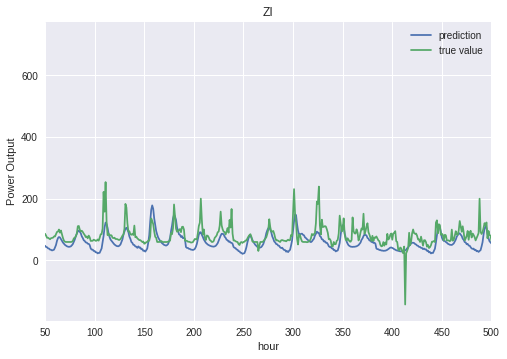

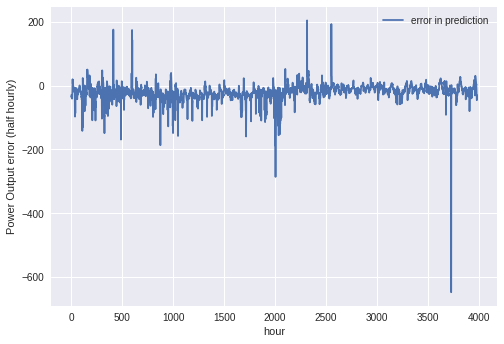

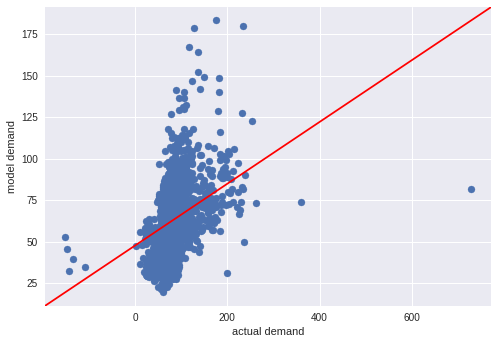

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

inits = {
#          'Xa_norm': tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode="FAN_AVG",uniform=True), 
#          'He': tf.keras.initializers.he_normal(),
#          'Identity': tf.keras.initializers.Identity(),
         'ZI': tf.zeros_initializer(),
#          'Xa_uniform': None,  # https://github.com/tensorflow/tensorflow/blob/2a0e004358f13d6ebe936ceab1b5e7d147606583/tensorflow/python/ops/init_ops.py#L1134
        }

hparams = build_hparams()
state = "QLD1" 
data_dir = "data/vars/"+state

# https://stackoverflow.com/a/27758326/4582711
def mean(data):
    """Return the sample arithmetic mean of data."""
    n = len(data)
    if n < 1:
        raise ValueError('mean requires at least one data point')
    return sum(data)/n # in Python 2 use sum(data)/float(n)

def _ss(data):
    """Return sum of square deviations of sequence data."""
    c = mean(data)
    ss = sum((x-c)**2 for x in data)
    return ss

def stddev(data, ddof=0):
    """Calculates the population standard deviation
    by default; specify ddof=1 to compute the sample
    standard deviation."""
    n = len(data)
    if n < 2:
        raise ValueError('variance requires at least two data points')
    ss = _ss(data)
    pvar = ss/(n-ddof)
    return pvar**0.5
  
# Restoring
mape_list = {'Xa_norm':[], 'He':[], 'Identity':[], 'ZI':[], 'Xa_uniform':[]}
pred_list = {'Xa_norm':[], 'He':[], 'Identity':[], 'ZI':[], 'Xa_uniform':[]}
true_list = {'Xa_norm':[], 'He':[], 'Identity':[], 'ZI':[], 'Xa_uniform':[]}
for init_name, init in inits.items():
    tf.reset_default_graph()
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, gpu_options=tf.GPUOptions(allow_growth=False))) as sess:
      inp = VarFeeder.read_vars(data_dir)
      pipe_test = InputPipe(inp, mode=ModelMode.EVAL, batch_size=1, 
                         n_epoch=1, verbose=False, 
                         train_window=hparams.train_window, predict_window=hparams.predict_window,
                         rand_seed=hparams.seed)
      test_model = Model(pipe_test, hparams, is_train=False, seed=hparams.seed, init=init, graph_prefix=None, 
                        asgd_decay=None)
      sess.run(tf.global_variables_initializer())
      inp.restore(sess)
      saver = tf.train.Saver(name='eval_saver')
      test_model.inp.init_iterator(sess)
      
      # Restore saved values
      print('\nRestoring model with ' + init_name + '...')
      saver_file = f"data/cpt/seq2seq/" + init_name + "/elf_seq2seq.ckpt"
      saver.restore(sess, saver_file)
      print('Ok')

      print("Testing the model")
      count = 0
      while True:
        try:
          error, pred, true, norm = sess.run([test_model.mape, test_model.predictions, 
                                        test_model.inp.y_true, test_model.inp.hits_norm])
          mape_list[init_name].append(error*100)
          pred_list[init_name].append(pred*norm)
          true_list[init_name].append(true*norm)
          count = count + 1
#           print("MAPE:", error*100)
        except tf.errors.OutOfRangeError:
          break
        
      print("Average MAPE:", mean(mape_list[init_name]))
      print("Population STD:", stddev(mape_list[init_name]))
      print("Sample STD:", stddev(mape_list[init_name], ddof=1))
      print("\n")

      plt.plot(range(len(np.ravel(pred_list[init_name]))), np.ravel(pred_list[init_name]), label='prediction')
      plt.plot(range(len(np.ravel(true_list[init_name]))), np.ravel(true_list[init_name]), label='true value')
      plt.xlim(50,500)
#       plt.ylim(7.5,10)
      plt.xlabel('hour')
      plt.ylabel('Power Output')
      plt.title(init_name)
      plt.legend()
      plt.show()
      
      error_list = np.ravel(pred_list[init_name]) - np.ravel(true_list[init_name])
      plt.plot(range(len(error_list)), error_list, label='error in prediction')
      plt.xlabel('hour')
      plt.ylabel('Power Output error (half hourly)')
      plt.legend()
      plt.show()
      
      fig, ax = plt.subplots()
      ax.scatter(np.ravel(true_list[init_name]), np.ravel(pred_list[init_name]))
      line = mlines.Line2D([0, 1], [0, 1], color='red')
      transform = ax.transAxes
      line.set_transform(transform)
      ax.add_line(line)
      plt.xlabel('actual demand')
      plt.ylabel('model demand')
      plt.show()

In [8]:
import math

def mape_fn(actual, predict): 
    tmp, n = 0.0, 0
    for i in range(actual.shape[0]):
        if actual[i] < 0 or actual[i] > 0:
            tmp += math.fabs(actual[i]-predict[i])/actual[i]
            n += 1
    return (tmp/n)

for init_name, init in inits.items():
  print("MAPE on Unnormalized data with",init_name, ":", mape_fn(np.ravel(true_list[init_name]), np.ravel(pred_list[init_name]))*100)

MAPE on Unnormalized data with ZI : 29.764414313235648


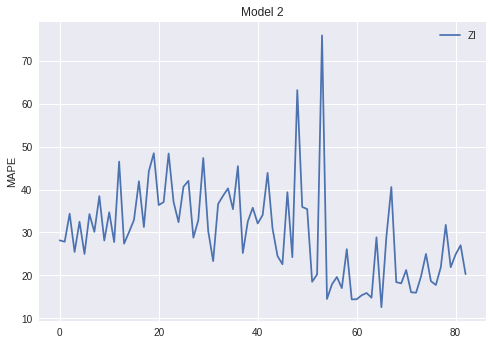

In [7]:
for init_name, init in inits.items():
  plt.plot(range(count), mape_list[init_name], label=init_name)
# plt.xlim(50,111)
# plt.ylim(0,4.5)
# plt.xlabel('epochs')
plt.ylabel('MAPE')
plt.title("Model 2")
plt.legend()
